In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import os

## Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

2. Оцените ошибку модели из п.2 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.
4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

In [36]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [37]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


In [38]:
d_data = data.resample('D').mean()
d_data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-01,31080.739130,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,0.0,0.0
2002-01-02,34261.541667,2002.0,1.0,2.0,1.0,2.0,1.0,2.0,11.5,0.0,0.0,1.0
2002-01-03,34511.875000,2002.0,1.0,3.0,1.0,3.0,1.0,3.0,11.5,0.0,0.0,0.0
2002-01-04,33715.458333,2002.0,1.0,4.0,1.0,4.0,1.0,4.0,11.5,0.0,0.0,0.0
2002-01-05,30405.125000,2002.0,1.0,5.0,1.0,5.0,1.0,5.0,11.5,0.0,0.0,0.0


Cглаживание

In [39]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [40]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW'], 0.05)

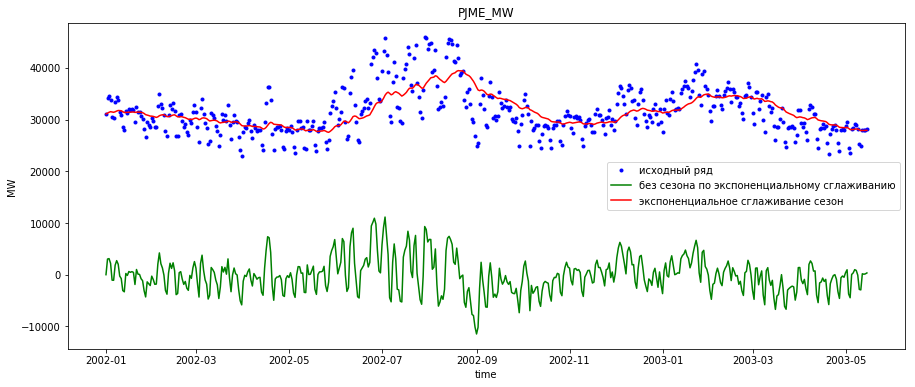

In [41]:
plt.figure(figsize=(15, 6))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], 
         '.b', label='исходный ряд')

plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500] - data_exp_1[:500], 
         color = 'green', label="без сезона по экспоненциальному сглаживанию")

plt.plot(d_data.index[:500], data_exp_1[:500], 
         color = 'red', label="экспоненциальное сглаживание сезон")

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW');

In [42]:
df = pd.DataFrame(data_exp_1, index=d_data.index)
df.head()

,0
Date,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621


In [43]:
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values

df.fillna(0)

df.head(10)

,0,t,t1,t2
Date,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257
2002-01-06,31406.309057,31463.294621,31518.987759,31403.384044
2002-01-07,31502.685270,31406.309057,31463.294621,31518.987759
2002-01-08,31645.696840,31502.685270,31406.309057,31463.294621
2002-01-09,31752.220331,31645.696840,31502.685270,31406.309057


In [44]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [45]:
train, test = split_data(df, '2017-01-01')

Прогноз h = 1

In [46]:
h = 1

X_train_1 = train.iloc[:-h,:]
y_train_1 = train[df.columns[0]].values[h:]
X_test_1 = test.iloc[:-h,:]
y_test_1 = test[df.columns[0]].values[h:]

In [47]:
stsc = StandardScaler()

In [48]:
X_train_1 = stsc.fit_transform(X_train_1)
X_test_1 = stsc.transform(X_test_1)

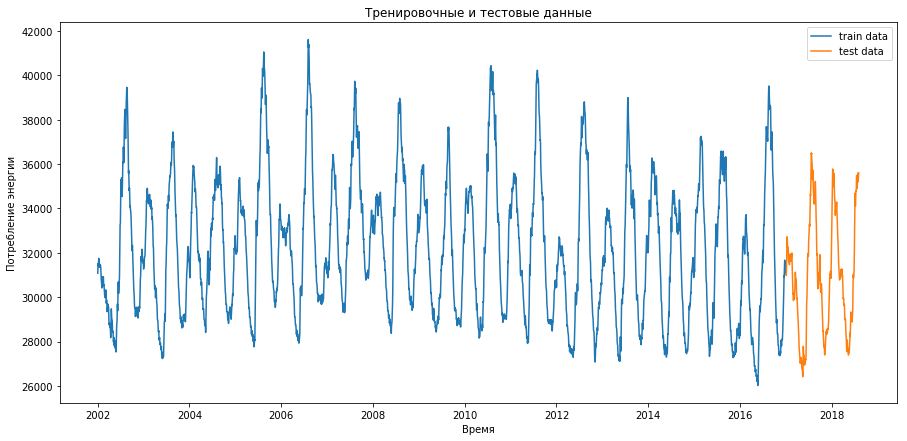

In [49]:
plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train.index.get_level_values('Date'), train[df.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'), test[df.columns[0]], label='test data')
plt.title('Тренировочные и тестовые данные')
plt.legend();

In [50]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
model_gb = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)

In [52]:
model_gb.fit(X_train_1, y_train_1) 
X_test_pred_gb = model_gb.predict(X_test_1)

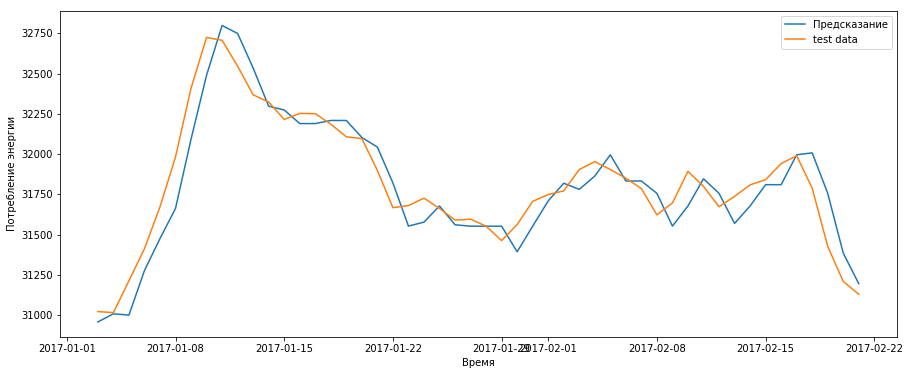

ошибка градиентного бустинга :   0.41834481250806754 %


In [53]:
plt.figure( figsize=(15, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h:h+50], X_test_pred_gb[:50], label='Предсказание')
plt.plot(test.index[h:h+50], y_test_1[:50], label='test data')

plt.legend()
plt.show()

er_g_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g_1, '%')

Прогноз h = 10

In [54]:
h = 10

X_train = train.iloc[:-h,:]
y_train = train[df.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[df.columns[0]].values[h:]

In [55]:
X_train = stsc.fit_transform(X_train)
X_test = stsc.transform(X_test)

In [56]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train, y_train ) 
X_test_pred_gb = model_gb.predict(X_test)

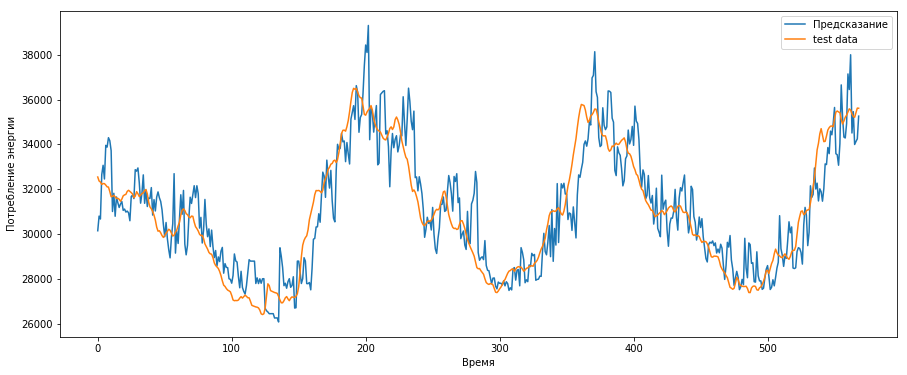

ошибка градиентного бустинга :   3.2091178507357467 %


In [57]:
plt.figure( figsize=(15, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(X_test_pred_gb, label='Предсказание')
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

In [58]:
print(f'Ошибка градиентного бустинга при h = 1 равна {er_g_1} %')
print(f'Ошибка градиентного бустинга при h = 10 равна {er_g} %')

Ошибка градиентного бустинга при h = 1 равна 0.41834481250806754 %
Ошибка градиентного бустинга при h = 10 равна 3.2091178507357467 %


Ошибка растет с увеличением h.